In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, classification_report, roc_curve, 
    roc_auc_score, confusion_matrix, precision_recall_curve,
    f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Import your models
from traditional_ml import predict_heart_disease        
from llm_model import prediction_by_llm

In [ ]:
# Load test sample
allData = pd.read_csv("heart.csv")
df = allData.sample(frac=0.3, random_state=42)

In [11]:
# Result collectors
true_labels = []
ensemble_preds = []
ensemble_probs = []
llm_preds = []
llm_probs = []
majority_preds = []
majority_probs = []

In [12]:
# Process each row
total_rows = len(df)
for idx, row in df.iterrows():
    
    # True label
    y_true = int(row['cardio'])
    true_labels.append(y_true)
    
    # -------------------------------------------------------------------------
    # Model 1: Traditional ML Ensemble (XGBoost + RF + Stacking)
    # -------------------------------------------------------------------------
    try:
        ensemble_output = predict_heart_disease(
            age=row['age'], 
            gender=row['gender'], 
            height=row['height'], 
            weight=row['weight'],
            ap_hi=row['ap_hi'], 
            ap_lo=row['ap_lo'], 
            cholesterol=row['cholesterol'], 
            gluc=row['gluc'],
            smoke=row['smoke'], 
            alco=row['alco'], 
            active=row['active'],
            age_in_days=True
        )
        ensemble_prob = ensemble_output["probability"]
        ensemble_pred = ensemble_output["prediction"]
    except Exception as e:
        print(f"\nWarning: Ensemble model failed on row {idx}: {e}")
        ensemble_prob = 0.0
        ensemble_pred = 0
    
    ensemble_preds.append(ensemble_pred)
    ensemble_probs.append(ensemble_prob)
    
    # -------------------------------------------------------------------------
    # Model 2: LLM-based prediction
    # -------------------------------------------------------------------------
    try:
        context = ""  # Optional: add medical context if needed
        llm_output = prediction_by_llm(
            row['age'], row['height'], row['weight'], row['gender'], 
            row['ap_hi'], row['ap_lo'], row['cholesterol'], row['gluc'], 
            row['smoke'], row['alco'], row['active'], context
        )
        
        # Parse LLM output - adjust based on your LLM output format
        llm_prob = 1.0 if '"has_heart_disease": true' in llm_output.lower() else 0.0
        llm_pred = int(llm_prob)
    except Exception as e:
        print(f"\nWarning: LLM model failed on row {idx}: {e}")
        llm_prob = 0.0
        llm_pred = 0
    
    llm_preds.append(llm_pred)
    llm_probs.append(llm_prob)
    
    # -------------------------------------------------------------------------
    # Model 3: Ensemble + LLM Combination (Majority Voting)
    # -------------------------------------------------------------------------
    # Average probabilities
    final_prob = (ensemble_prob + llm_prob) / 2.0
    # Decision threshold
    final_pred = 1 if final_prob >= 0.7 else 0
    
    majority_preds.append(final_pred)
    majority_probs.append(final_prob)

print(f"\nProcessed all {total_rows} rows")


Processed all 1400 rows


In [13]:
print("PERFORMANCE METRICS")
print("="*80)

def calculate_metrics(y_true, y_pred, y_prob, model_name):
    """Calculate comprehensive metrics for a model"""
    print(f"\n{model_name}")
    print("-" * 60)
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    
    # ROC-AUC (if probabilities are available and not all same)
    if len(set(y_prob)) > 1:
        auc = roc_auc_score(y_true, y_prob)
        print(f"ROC-AUC:   {auc:.4f}")
    else:
        auc = None
        print(f"ROC-AUC:   N/A (constant predictions)")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted")
    print(f"                 0        1")
    print(f"Actual 0    {cm[0,0]:6d}   {cm[0,1]:6d}")
    print(f"Actual 1    {cm[1,0]:6d}   {cm[1,1]:6d}")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm
    }


PERFORMANCE METRICS


In [14]:
# Evaluate each model
metrics_ensemble = calculate_metrics(true_labels, ensemble_preds, ensemble_probs, 
                                     "MODEL 1: Traditional ML Ensemble")
metrics_llm = calculate_metrics(true_labels, llm_preds, llm_probs, 
                                "MODEL 2: LLM-based Prediction")
metrics_combined = calculate_metrics(true_labels, majority_preds, majority_probs, 
                                     "MODEL 3: Combined (Ensemble + LLM)")


MODEL 1: Traditional ML Ensemble
------------------------------------------------------------
Accuracy:  0.6671 (66.71%)
Precision: 0.6106
Recall:    0.9124
F1 Score:  0.7316
ROC-AUC:   0.8115

Confusion Matrix:
                 Predicted
                 0        1
Actual 0       299      405
Actual 1        61      635

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.42      0.56       704
           1       0.61      0.91      0.73       696

    accuracy                           0.67      1400
   macro avg       0.72      0.67      0.65      1400
weighted avg       0.72      0.67      0.65      1400


MODEL 2: LLM-based Prediction
------------------------------------------------------------
Accuracy:  0.4864 (48.64%)
Precision: 0.4806
Recall:    0.4095
F1 Score:  0.4422
ROC-AUC:   0.4860

Confusion Matrix:
                 Predicted
                 0        1
Actual 0       396      308
Actual 1       411      285

Cla

In [15]:
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Traditional ML', 'LLM', 'Combined'],
    'Accuracy': [metrics_ensemble['accuracy'], metrics_llm['accuracy'], metrics_combined['accuracy']],
    'Precision': [metrics_ensemble['precision'], metrics_llm['precision'], metrics_combined['precision']],
    'Recall': [metrics_ensemble['recall'], metrics_llm['recall'], metrics_combined['recall']],
    'F1 Score': [metrics_ensemble['f1'], metrics_llm['f1'], metrics_combined['f1']],
    'ROC-AUC': [metrics_ensemble['auc'], metrics_llm['auc'], metrics_combined['auc']]
})

print("\n", comparison_df.to_string(index=False))


MODEL COMPARISON

          Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC
Traditional ML  0.667143   0.610577 0.912356  0.731567 0.811511
           LLM  0.486429   0.480607 0.409483  0.442203 0.485991
      Combined  0.594286   0.706452 0.314655  0.435388 0.646264


In [16]:
# Find best model
best_model_idx = comparison_df['F1 Score'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
print(f"\nBest performing model: {best_model}")


Best performing model: Traditional ML



GENERATING VISUALIZATIONS
Saved: model_comparison.png


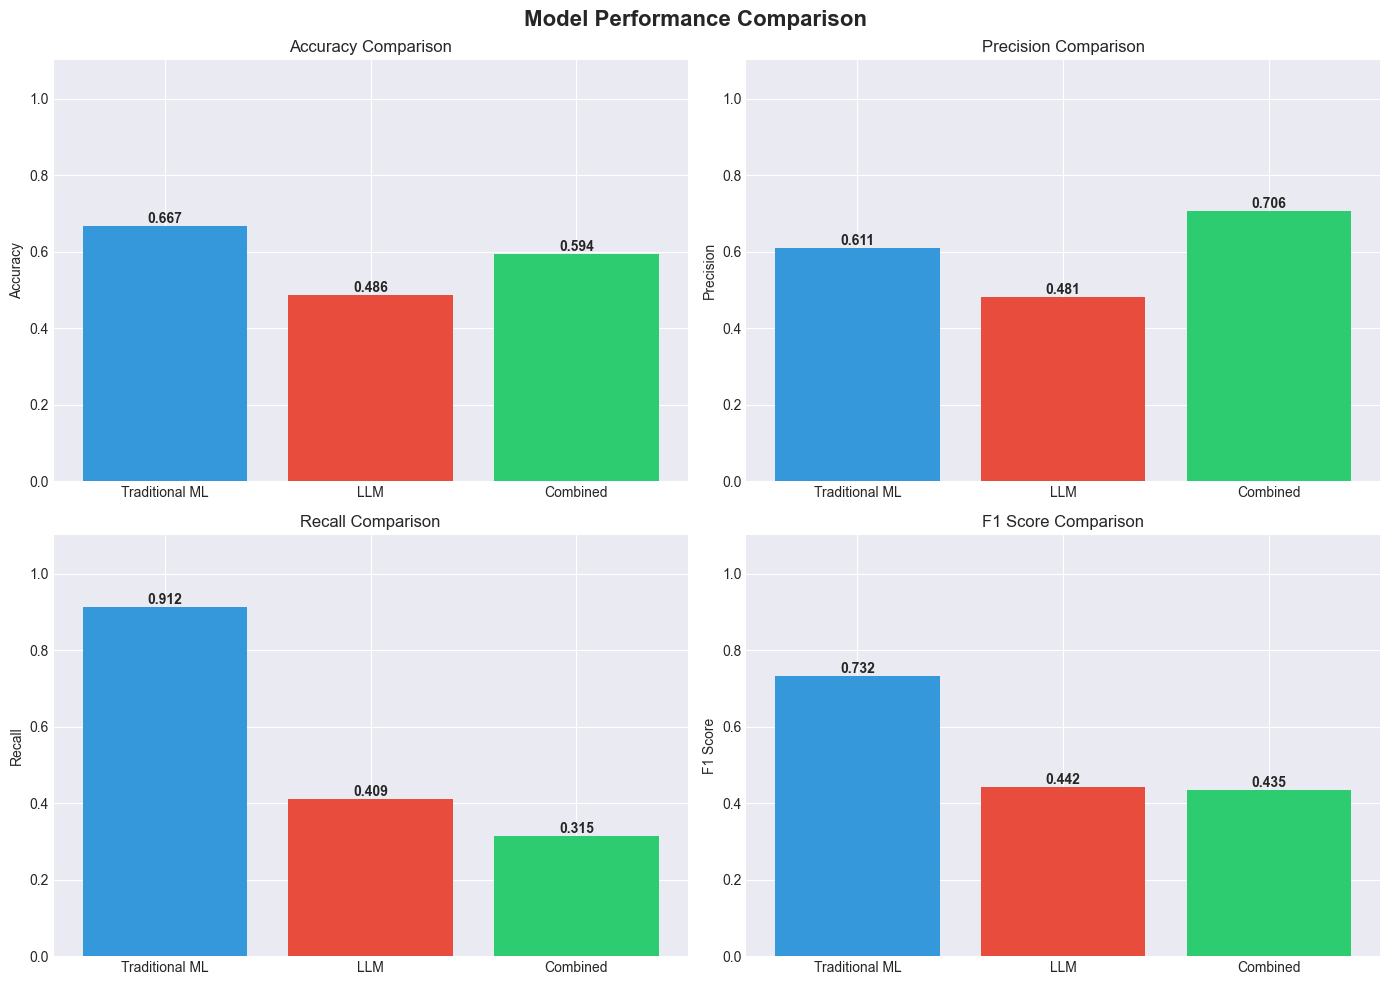

In [17]:
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Figure 1: Performance Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Accuracy comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models = ['Traditional ML', 'LLM', 'Combined']

for idx, metric in enumerate(metrics_names):
    ax = axes[idx // 2, idx % 2]
    values = comparison_df[metric].values
    bars = ax.bar(models, values, color=['#3498db', '#e74c3c', '#2ecc71'])
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1.1])
    ax.set_title(f'{metric} Comparison')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: model_comparison.png")

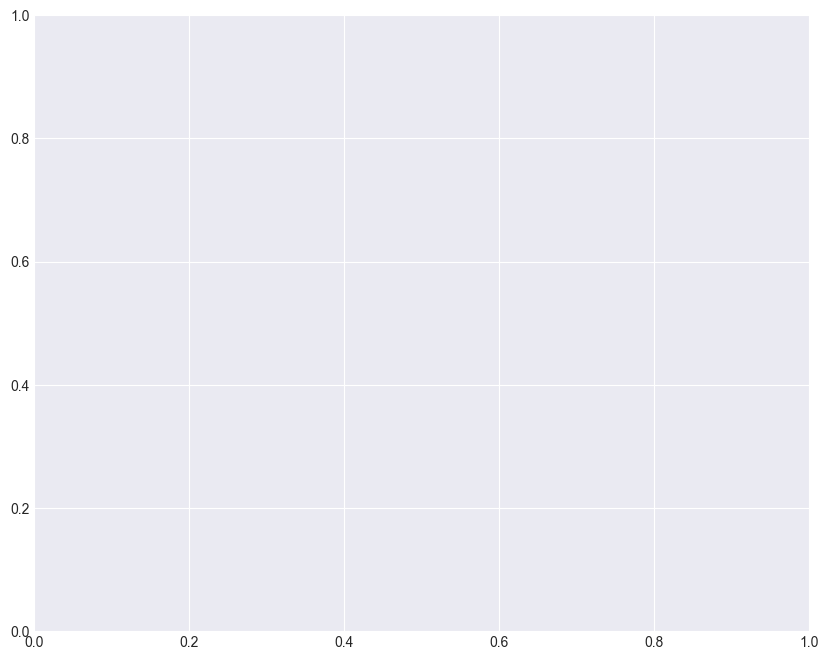

In [18]:
# Figure 2: ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

In [19]:
# Plot ROC curve for each model
colors = ['#3498db', '#e74c3c', '#2ecc71']
for probs, preds, name, color in zip(
    [ensemble_probs, llm_probs, majority_probs],
    [ensemble_preds, llm_preds, majority_preds],
    ['Traditional ML', 'LLM', 'Combined'],
    colors
):
    if len(set(probs)) > 1:  # Only plot if we have varying probabilities
        fpr, tpr, _ = roc_curve(true_labels, probs)
        auc = roc_auc_score(true_labels, probs)
        ax.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', 
                color=color, linewidth=2)

In [20]:
# Plot diagonal
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
print("Saved: roc_curves.png")

Saved: roc_curves.png


<Figure size 640x480 with 0 Axes>

Saved: confusion_matrices.png


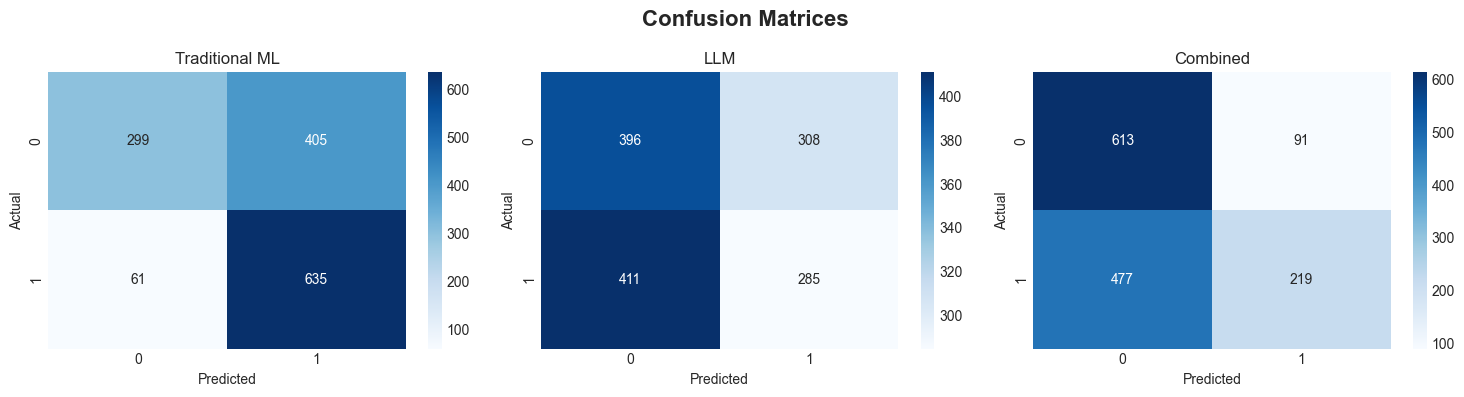

In [21]:
# Figure 3: Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

for idx, (cm, name) in enumerate(zip(
    [metrics_ensemble['confusion_matrix'], 
     metrics_llm['confusion_matrix'], 
     metrics_combined['confusion_matrix']],
    ['Traditional ML', 'LLM', 'Combined']
)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                ax=axes[idx], cbar=True)
    axes[idx].set_title(name)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
print("Saved: confusion_matrices.png")

In [22]:
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save predictions
results_df = pd.DataFrame({
    'true_label': true_labels,
    'ensemble_pred': ensemble_preds,
    'ensemble_prob': ensemble_probs,
    'llm_pred': llm_preds,
    'llm_prob': llm_probs,
    'combined_pred': majority_preds,
    'combined_prob': majority_probs
})
results_df.to_csv('prediction_results.csv', index=False)
print("Saved: prediction_results.csv")

# Save comparison metrics
comparison_df.to_csv('model_comparison.csv', index=False)
print("Saved: model_comparison.csv")

print("\n" + "="*80)
print("EVALUATION COMPLETE!")
print("="*80)
print(f"\nFiles generated:")
print("  1. prediction_results.csv - All predictions and probabilities")
print("  2. model_comparison.csv - Performance metrics comparison")
print("  3. model_comparison.png - Performance metrics visualization")
print("  4. roc_curves.png - ROC curves for all models")
print("  5. confusion_matrices.png - Confusion matrices visualization")


SAVING RESULTS
Saved: prediction_results.csv
Saved: model_comparison.csv

EVALUATION COMPLETE!

Files generated:
  1. prediction_results.csv - All predictions and probabilities
  2. model_comparison.csv - Performance metrics comparison
  3. model_comparison.png - Performance metrics visualization
  4. roc_curves.png - ROC curves for all models
  5. confusion_matrices.png - Confusion matrices visualization
